In [27]:
import pandas as pd
import matplotlib.pyplot as plt


In [28]:
df = pd.read_csv('srpski.csv', sep='\t')
df = df.drop(columns=['Rbr', 'SR', 'sr/sr', 'Naslov', 'Jezik'])
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].str.lower()
df

,Autor,Tekst
0,1,"padajte, braćo, plin'te u krvi! ostav'te sela ..."
1,1,"mudraci su prinosili dara: smirnu, zlato, caru..."
2,1,mnogi me je dosad zapitkiv’o: sa čega sam srca...
3,1,"ja sam stena, o koju se zloba mori, svetska ču..."
4,1,kroz ponoć nemu i gusto granje vidi se zvezda ...
...,...,...
133,2,"ostale su za mnom bašte jorgovana, sjaj prolje..."
134,2,"popô si se sred milina, dvor ti zlato, svila k..."
135,13,već sanduk zatvaraju čvrsto da večno budeš ple...
136,13,"ne pitaj me o bosforu više, ja ti ne znam odgo..."


Tokenizacija reci i recenica


In [29]:
import re
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktLanguageVars

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jelenalazovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
class LangVars(PunktLanguageVars):
    sent_end_chars = ('.', '!', '?', ';', ":", "...", '..','…')
custom_sent_tokenizer = PunktSentenceTokenizer(lang_vars=LangVars())
df['Recenice'] = df['Tekst'].apply(custom_sent_tokenizer.tokenize)

In [31]:
custom_tokenizer = RegexpTokenizer(r'\w+[\'\’]*\w*|[^\w\s]')
df['Tokeni'] = df['Tekst'].apply(custom_tokenizer.tokenize)

In [32]:
punctuation = r'[^\w\s]'
def remove_punctuation(tokens): 
    filtered_tokens = [word for word in tokens if not re.match(punctuation, word)]
    return filtered_tokens

df['Filtrirani tokeni'] = df['Tokeni'].apply(remove_punctuation)

In [33]:
from nltk import FreqDist

In [34]:
all_words = [word for words in df['Filtrirani tokeni'] for word in words]
fdist = FreqDist(all_words)
stopwords = [word for word, count in fdist.items() if count > 50 or (len(word) in (1,2,3) and count > 20)]

In [35]:
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return filtered_tokens

#df['Filtrirani tokeni'] = df['Filtrirani tokeni'].apply(remove_stopwords)

Podela podataka na trening i test

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X = df[['Tekst', 'Recenice', 'Tokeni','Filtrirani tokeni']]
y = df['Autor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Stilometrijske analize

In [38]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


In [39]:
def average_word_length(words):
    return sum(len(word) for word in words) / len(words)

df_train['Duzina reci'] = df_train['Filtrirani tokeni'].apply(average_word_length)
df_test['Duzina reci'] = df_test['Filtrirani tokeni'].apply(average_word_length)


In [40]:
df_avgWordLength = df_train.groupby('Autor')['Duzina reci'].mean().reset_index()

In [41]:
import matplotlib.pyplot as plt


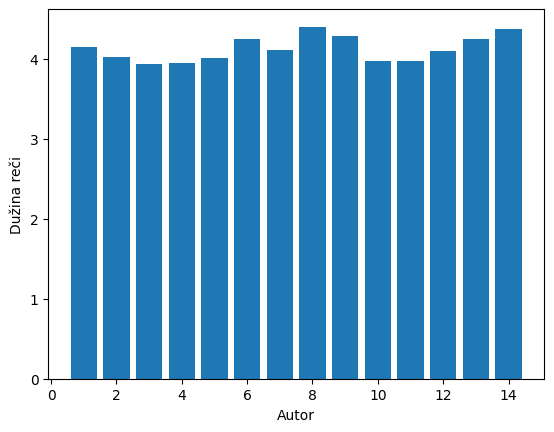

In [42]:
plt.bar(df_avgWordLength['Autor'], df_avgWordLength['Duzina reci'])
plt.xlabel('Autor')
plt.ylabel('Dužina reči')
plt.show()

In [43]:
def average_sentence_length(sentences):
    return sum(len(sentence.split()) for sentence in sentences) / len(sentences)

df_train['Duzina recenica'] = df_train['Recenice'].apply(average_sentence_length)
df_test['Duzina recenica'] = df_test['Recenice'].apply(average_sentence_length)


In [44]:
df_avgSentLength = df_train.groupby('Autor')['Duzina recenica'].mean().reset_index()


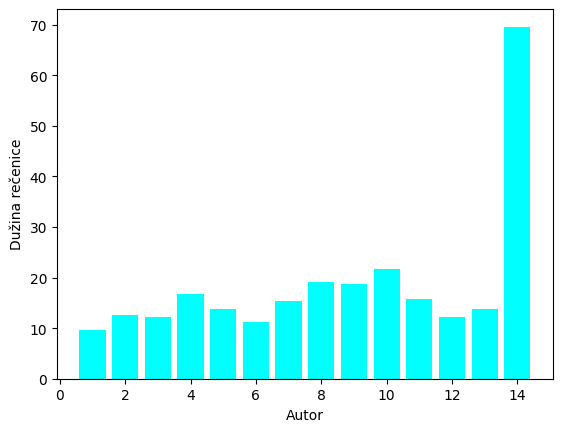

In [45]:
plt.bar(df_avgSentLength['Autor'], df_avgSentLength['Duzina recenica'], color='cyan')
plt.xlabel('Autor')
plt.ylabel('Dužina rečenice')
plt.show()

In [46]:
def text_length(words):
    return sum(len(word) for word in words)
df_train['Duzina teksta'] = df_train['Tokeni'].apply(text_length)
df_test['Duzina teksta'] = df_test['Tokeni'].apply(text_length)

In [47]:
df_avgTextLength = df_train.groupby('Autor')['Duzina teksta'].mean().reset_index()


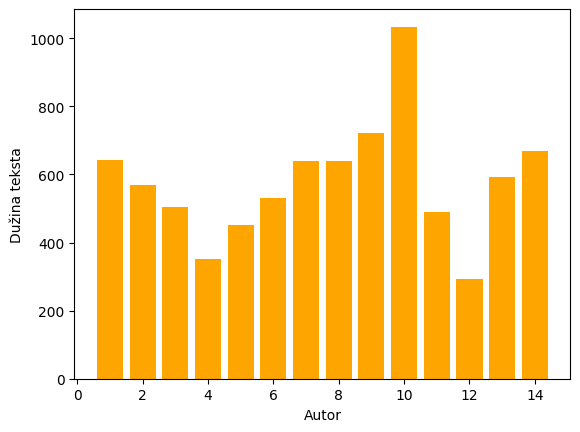

In [48]:
plt.bar(df_avgTextLength['Autor'], df_avgTextLength['Duzina teksta'], color='orange')
plt.xlabel('Autor')
plt.ylabel('Dužina teksta')
plt.show()

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier(max_depth=5,min_samples_split=15, n_estimators=300)
model.fit(df_train[['Duzina reci', 'Duzina recenica', 'Duzina teksta']],df_train['Autor'])
y_pred = model.predict(df_test[['Duzina reci', 'Duzina recenica', 'Duzina teksta']])
report = accuracy_score(df_test['Autor'], y_pred)
report

0.2619047619047619

In [50]:
from sklearn.naive_bayes import MultinomialNB

classifierMB = MultinomialNB()
#df_random = pd.DataFrame(X_train.toarray(), columns= vectorizer.get_feature_names_out())
classifierMB.fit(df_train[['Duzina reci', 'Duzina recenica', 'Duzina teksta']],df_train['Autor'])
y_pred = classifierMB.predict(df_test[['Duzina reci','Duzina recenica', 'Duzina teksta']])
report = accuracy_score(df_test['Autor'], y_pred)
report

0.14285714285714285